## 1. Setup and Imports

This section imports all necessary libraries for loading data, generating SciBERT embeddings, and running XGBoost classification.

In [2]:
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModel
import torch
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix

## 2. Load Cleaned Discipline Dataset

In [3]:
df = pd.read_csv('Data/Discipline (1138).csv')
print(df.shape)
df.head()

(1138, 4)


,Title,Abstract,Discipline,Link
0,VITA-Audio: Fast Interleaved Cross-Modal Token...,With the growing requirement for natural human...,CS,http://arxiv.org/abs/2505.03739v1
1,AMO: Adaptive Motion Optimization for Hyper-De...,Humanoid robots derive much of their dexterity...,CS,http://arxiv.org/abs/2505.03738v1
2,FlexiAct: Towards Flexible Action Control in H...,Action customization involves generating video...,CS,http://arxiv.org/abs/2505.03730v1
3,Actor-Critics Can Achieve Optimal Sample Effic...,Actor-critic algorithms have become a cornerst...,CS,http://arxiv.org/abs/2505.03710v1
4,Demonstrating ViSafe: Vision-enabled Safety fo...,Assured safe-separation is essential for achie...,CS,http://arxiv.org/abs/2505.03694v1


## 3. Prepare Input Text

Concatenate Title and Abstract for each paper to create the input text for SciBERT embedding extraction.

In [4]:
df['input_text'] = df['Title'].astype(str) + ' ' + df['Abstract'].astype(str)
df['input_text'].head()

0    VITA-Audio: Fast Interleaved Cross-Modal Token...
1    AMO: Adaptive Motion Optimization for Hyper-De...
2    FlexiAct: Towards Flexible Action Control in H...
3    Actor-Critics Can Achieve Optimal Sample Effic...
4    Demonstrating ViSafe: Vision-enabled Safety fo...
Name: input_text, dtype: object

## 4. Load SciBERT Tokenizer and Model

We use the 'allenai/scibert_scivocab_uncased' model from HuggingFace.

In [5]:
from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained('allenai/scibert_scivocab_uncased')
model = AutoModel.from_pretrained('allenai/scibert_scivocab_uncased')
model.eval()  # Always set model to eval mode for inference

# Move to GPU if available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(31090, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

## 5. Generate 768-Dimensional SciBERT Embeddings

Batch process the input text using SciBERT. For each paper, use mean pooling over the output embeddings.

In [6]:
from tqdm import tqdm
import numpy as np
import torch

def get_scibert_embeddings(texts, batch_size=16, device='cpu'):
    model.to(device)
    embeddings = []
    with torch.no_grad():
        for i in tqdm(range(0, len(texts), batch_size)):
            batch = texts[i:i+batch_size]
            encoded = tokenizer(batch, padding=True, truncation=True, max_length=256, return_tensors='pt')
            input_ids = encoded['input_ids'].to(device)
            attention_mask = encoded['attention_mask'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask)
            # Mean pooling
            emb = (outputs.last_hidden_state * attention_mask.unsqueeze(-1)).sum(1) / attention_mask.sum(1, keepdim=True)
            embeddings.append(emb.cpu().numpy())
    return np.vstack(embeddings)

embeddings = get_scibert_embeddings(df['input_text'].tolist(), batch_size=16, device=device)
print("Embeddings shape:", embeddings.shape)

100%|███████████████████████████████████████████| 72/72 [01:15<00:00,  1.05s/it]

Embeddings shape: (1138, 768)


In [7]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y = le.fit_transform(df['Discipline'])
print(list(zip(le.classes_, range(len(le.classes_)))))

[('CS', 0), ('IS', 1), ('IT', 2)]


## 6. Save Embeddings for Reuse

Save the computed SciBERT embeddings to avoid recomputing in the future.

In [8]:
import joblib

# Save in Artefacts
joblib.dump(embeddings, 'Artefacts/scibert_embeddings_discipline_v2.2.pkl')
joblib.dump(le, 'Artefacts/discipline_label_encoder_v2.2.pkl')

['Artefacts/discipline_label_encoder_v2.2.pkl']

## 8. Train-Test Split

We split the embeddings and labels into training and testing sets (80/20 stratified split).

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    embeddings, y, test_size=0.2, stratify=y, random_state=42
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (910, 768)
Test shape: (228, 768)


## 9. Train XGBoost Classifier

In [10]:
from xgboost import XGBClassifier

clf = XGBClassifier(
    tree_method='gpu_hist' if torch.cuda.is_available() else 'auto',
    random_state=42,
    eval_metric='mlogloss'
)
clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

## 10. Evaluate Model Performance

Prints classification report and confusion matrix.

In [11]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=le.classes_))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

          CS       0.91      0.95      0.93        95
          IS       0.90      0.95      0.93        88
          IT       0.92      0.73      0.81        45

    accuracy                           0.91       228
   macro avg       0.91      0.88      0.89       228
weighted avg       0.91      0.91      0.91       228

Confusion Matrix:
 [[90  4  1]
 [ 2 84  2]
 [ 7  5 33]]


## 11. Visualize Confusion Matrix

Plot a heatmap to better understand class-wise performance.

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


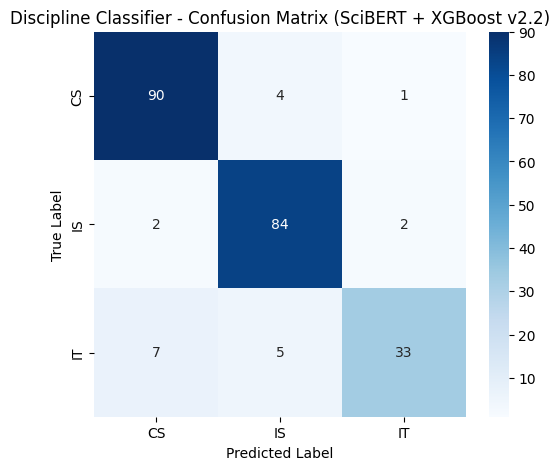

In [12]:
!pip install seaborn

import matplotlib.pyplot as plt
import seaborn as sns

# Compute matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Discipline Classifier - Confusion Matrix (SciBERT + XGBoost v2.2)")
plt.show()

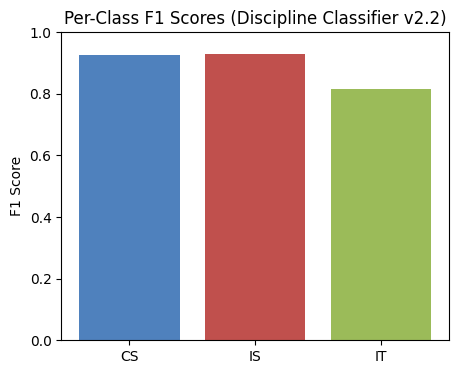

In [13]:
# Get per-class metrics as dict
report = classification_report(y_test, y_pred, target_names=le.classes_, output_dict=True)

f1_scores = [report[label]['f1-score'] for label in le.classes_]

plt.figure(figsize=(5, 4))
plt.bar(le.classes_, f1_scores, color=["#4F81BD", "#C0504D", "#9BBB59"])
plt.ylim(0, 1)
plt.ylabel("F1 Score")
plt.title("Per-Class F1 Scores (Discipline Classifier v2.2)")
plt.show()

## 12.Save the Trained XGBoost Model

We save the classifier for future inference or deployment.

In [14]:
joblib.dump(clf, 'Artefacts/disc_scibert_xgboost_v2.2.pkl')

['Artefacts/disc_scibert_xgboost_v2.2.pkl']

## Results Summary

**Final Results: Discipline Classifier (SciBERT + XGBoost, v2.2)**

- **Test Accuracy:** `0.91`
- **Macro F1 Score:** `0.89`

**Per-Class F1 Scores:**
- **CS:** `0.93`
- **IS:** `0.93`
- **IT:** `0.81`

**Key Observations:**
- The classifier achieves **excellent accuracy** on CS and IS papers, with slightly lower recall and F1 on IT, likely due to its smaller class size and some overlap with CS/IS research areas.
- **Most IT misclassifications** are predicted as CS or IS (see confusion matrix above), suggesting some remaining topic ambiguity or class imbalance.
- Overall, **SciBERT embeddings + XGBoost** provide a significant boost in performance over traditional TF-IDF pipelines.

**Visualizations Included:**
- Confusion matrix heatmap (above)
- Per-class F1 bar chart (above)

---

**All model artefacts, embeddings, and encoders have been saved to the `Artefacts/` directory for reproducibility and future use.**